# ML pipeline for a single assay endpoint

### Imports

In [15]:
import os
import yaml
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


### Load assay endpoint and QSAR-ready chemical structure fingerprints
Note: Many chemicals from assays do not have a fingerprint -> small training data

In [27]:
# Define the root directory
ROOT_DIR = os.path.dirname(os.path.abspath("__file__"))
CONFIG_PATH = os.path.join(ROOT_DIR, 'config', 'config_ml.yaml')


def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
        if config["ignore_warnings"]:
            import warnings
            warnings.filterwarnings("ignore")

    return config  

 
config = load_config(CONFIG_PATH)

# Get the configuration parameters
aeid = config['aeid']
print(f"ML pipeline for assay ID: {aeid}\n")

random_state = config['random_state']
train_test_split_ratio = config['train_test_split_ratio']

# Define the file paths
assay_file_path = os.path.join(ROOT_DIR, 'export', 'out', f'{aeid}.csv')
fps_file_path = os.path.join(ROOT_DIR, 'input', 'df_sirius_fps.csv')  # 

# Read the CSV files
assay_df = pd.read_csv(assay_file_path)
fps_df = pd.read_csv(fps_file_path)

# Drop the duplicates in the fingerprint dataframe
fps_df = fps_df.drop_duplicates(subset="dtxsid")

# Get the dtxsid values as lists
intersection = pd.Index(assay_df["dtxsid"]).intersection(fps_df["dtxsid"])

print(f"Fingerprint dataframe shape: {fps_df.shape}")
print(f"Assay dataframe shape: {assay_df.shape}")
print()

df = pd.merge(assay_df, fps_df, on="dtxsid").reset_index(drop=True)
print(f"Number of datapoints for this ML pipeline: {df['dtxsid'].nunique()}")

assert df.shape[0] == len(intersection)


ML pipeline for assay ID: 784

Fingerprint dataframe shape: (5171, 2364)
Assay dataframe shape: (8305, 2)

Number of datapoints for this ML pipeline: 1045


### Split data into train and test sets

In [28]:
config = load_config(CONFIG_PATH)

# Split the data into features (X) and labels (y)
X = df.iloc[:, 2:]  # Select all columns starting from the third column as features
y = df['hitc']  

print(f"Label Counts, total: {len(y)} datapoints")
print(y.value_counts())

# Split the data into train and test sets before oversampling to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_ratio, random_state=random_state)

# Perform SMOTE oversampling?
if config['apply']['smote']:
    oversampler = SMOTE(random_state=random_state)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


Label Counts, total: 1045 datapoints
hitc
False    866
True     179
Name: count, dtype: int64


### Build classifier pipeline

In [29]:
config = load_config(CONFIG_PATH)

# build for each classifier a pipeline with the steps defined in the config file
def build_pipeline(steps):
    pipeline_steps = []
    for step in steps:
        step_name = step['name']  
        step_args = step.get('args', {}) # get the hyperparameters for the step, if any
        step_instance = globals()[step_name](**step_args)  # dynmically create an instance of the step
        pipeline_steps.append((step_name, step_instance))  
    return Pipeline(pipeline_steps)


def build_param_grid(classifier_steps):
    param_grid = {}
    for step in classifier_steps:
        step_name = step['name']
        step_args = step.get('args', {})
        param_grid.update({f'{step_name}__{key}': value for key, value in step_args.items() if isinstance(value, list)})
    return param_grid


def grid_search_cv(classifier, pipeline):
    grid_search = GridSearchCV(pipeline, 
                               param_grid=build_param_grid(classifier['steps']),
                               cv=5, 
                               scoring=config["grid_search_cv_scoring"]
                               ).fit(X_train, y_train)
    
    print(f"{classifier['name']}: GridSearchCV Results:")
    best_params = grid_search.best_params_ if grid_search.best_params_ else "default"
    print(f"Best params:\n{best_params} with mean cross-validated score: {grid_search.best_score_}\n")

    return grid_search


def predict_and_report(classifier, best_estimator):
    print(f"Predict..")
    y_pred = best_estimator.predict(X_test)

    labels = [True, False] 
    print(f"Classification Report {classifier['name']}:")
    print(classification_report(y_test, y_pred, labels=labels))

    cm = confusion_matrix(y_test, y_pred, labels=labels)
    tn, fp, fn, tp = cm.ravel()   # Extract values from confusion matrix
    print(f"Total: {len(y_test)} datapoints")
    print(f"Ground truth: {tn + fp} positive, {tp + fn} negative")
    print(f"Prediction: {tn + fn} positive, {tp + fp} negative")

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Positive", "Negative"])
    cm_display.plot()
    plt.title(f"Cofusion Matrix for {classifier['name']}")
    plt.show()
    

### Pipeline: Grid Search CV + Prediction + Classification report

SVC: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.0

Predict..
Classification Report SVC:
              precision    recall  f1-score   support

        True       0.00      0.00      0.00        34
       False       0.84      1.00      0.91       175

    accuracy                           0.84       209
   macro avg       0.42      0.50      0.46       209
weighted avg       0.70      0.84      0.76       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 0 positive, 209 negative


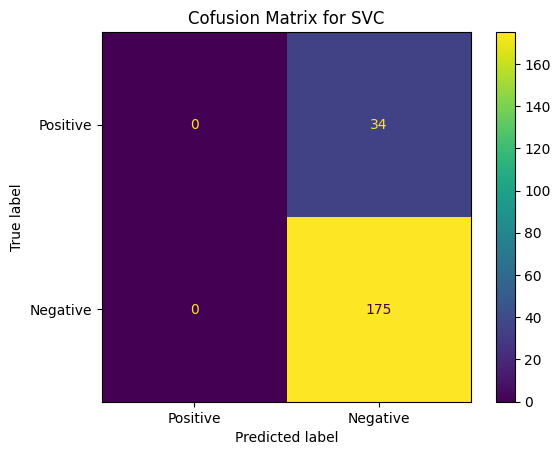

Done: SVC >> 1.58 seconds.
___________________________________________________________________________


KNeighborsClassifier: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.2753713836491398

Predict..
Classification Report KNeighborsClassifier:
              precision    recall  f1-score   support

        True       0.38      0.18      0.24        34
       False       0.85      0.94      0.90       175

    accuracy                           0.82       209
   macro avg       0.61      0.56      0.57       209
weighted avg       0.78      0.82      0.79       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 16 positive, 193 negative


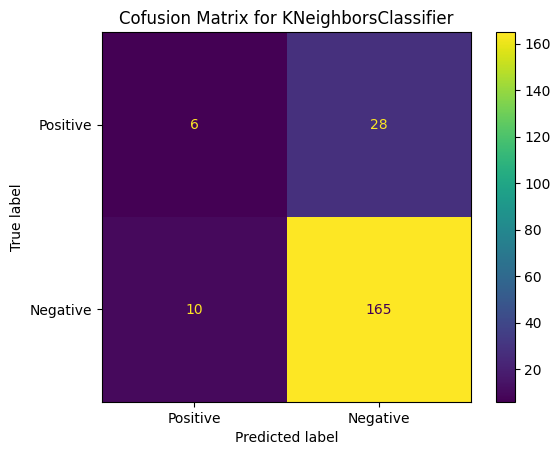

Done: KNeighborsClassifier >> 6.09 seconds.
___________________________________________________________________________


GaussianNB: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.40066529961266806

Predict..
Classification Report GaussianNB:
              precision    recall  f1-score   support

        True       0.24      0.65      0.35        34
       False       0.90      0.60      0.72       175

    accuracy                           0.61       209
   macro avg       0.57      0.62      0.53       209
weighted avg       0.79      0.61      0.66       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 92 positive, 117 negative


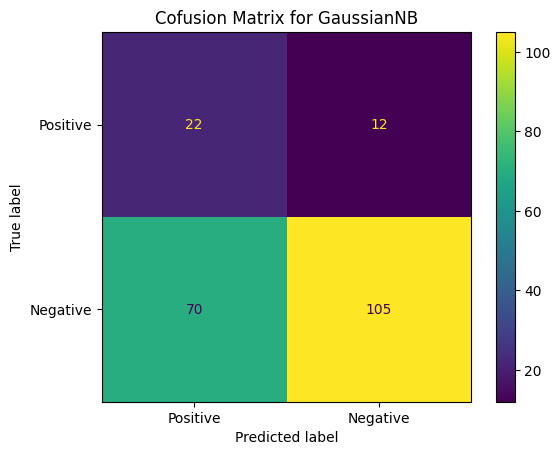

Done: GaussianNB >> 6.29 seconds.
___________________________________________________________________________


AdaBoostClassifier: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.5452854581600419

Predict..
Classification Report AdaBoostClassifier:
              precision    recall  f1-score   support

        True       0.58      0.41      0.48        34
       False       0.89      0.94      0.92       175

    accuracy                           0.86       209
   macro avg       0.74      0.68      0.70       209
weighted avg       0.84      0.86      0.85       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 24 positive, 185 negative


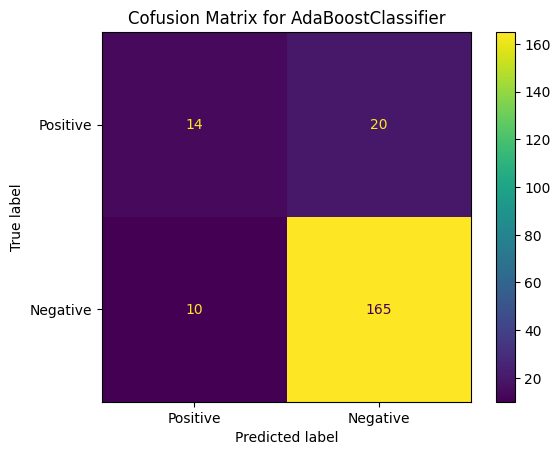

Done: AdaBoostClassifier >> 4.94 seconds.
___________________________________________________________________________


RandomForestClassifier: GridSearchCV Results:
Best params:
{'RandomForestClassifier__n_estimators': 150} with mean cross-validated score: 0.6858416945373467

Predict..
Classification Report RandomForestClassifier:
              precision    recall  f1-score   support

        True       0.74      0.50      0.60        34
       False       0.91      0.97      0.94       175

    accuracy                           0.89       209
   macro avg       0.82      0.73      0.77       209
weighted avg       0.88      0.89      0.88       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 23 positive, 186 negative


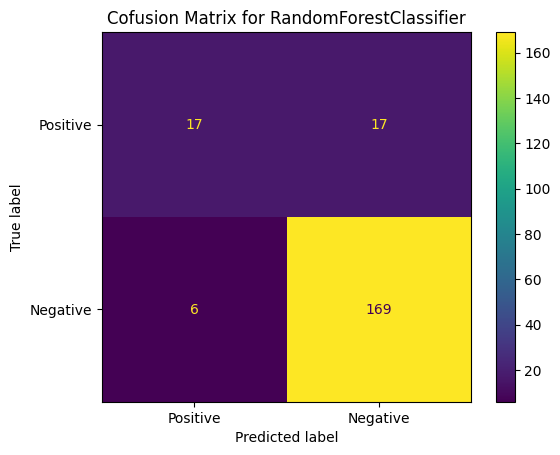

Done: RandomForestClassifier >> 3.84 seconds.
___________________________________________________________________________


XGBClassifier: GridSearchCV Results:
Best params:
{'XGBClassifier__n_estimators': 100} with mean cross-validated score: 0.6890321656279104

Predict..
Classification Report XGBClassifier:
              precision    recall  f1-score   support

        True       0.69      0.53      0.60        34
       False       0.91      0.95      0.93       175

    accuracy                           0.89       209
   macro avg       0.80      0.74      0.77       209
weighted avg       0.88      0.89      0.88       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 26 positive, 183 negative


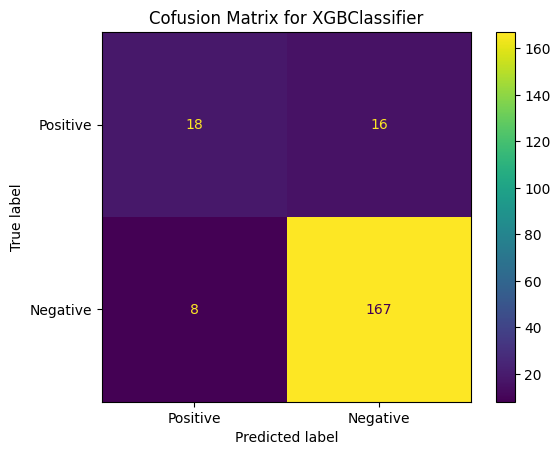

Done: XGBClassifier >> 35.64 seconds.
___________________________________________________________________________


MLPClassifier: GridSearchCV Results:
Best params:
default with mean cross-validated score: 0.5804176227357477

Predict..
Classification Report MLPClassifier:
              precision    recall  f1-score   support

        True       0.50      0.50      0.50        34
       False       0.90      0.90      0.90       175

    accuracy                           0.84       209
   macro avg       0.70      0.70      0.70       209
weighted avg       0.84      0.84      0.84       209

Total: 209 datapoints
Ground truth: 34 positive, 175 negative
Prediction: 34 positive, 175 negative


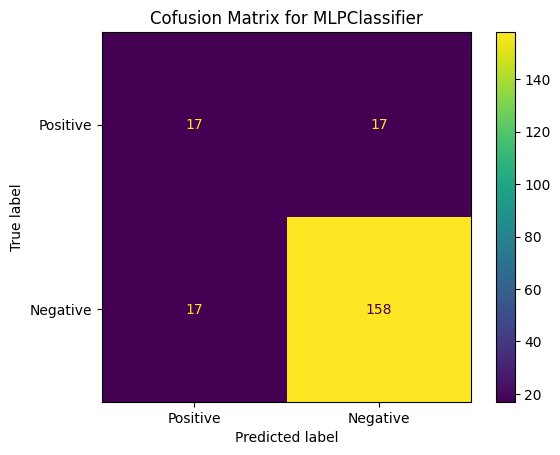

Done: MLPClassifier >> 31.12 seconds.
___________________________________________________________________________




In [30]:
config = load_config(CONFIG_PATH)

for classifier in config['classifiers']:
    start_time = time.time()
    
    # Build the pipeline for the current classifier
    pipeline = build_pipeline(classifier['steps'])

    # Perform grid search on the extracted hyperparameters
    grid_search = grid_search_cv(classifier, pipeline)

    # Predict on the test set and best estimator
    predict_and_report(classifier, grid_search.best_estimator_)

    print(f"Done: {classifier['name']} >> {round(time.time() - start_time, 2)} seconds.\n{'_' * 75}\n\n")
    